#Segmentation of low-contrast touching objects 

This tutorial explains how to segment an image composed of similar-looking objects connected by low-contrast boundaries, using ``scikit-image`` as well as other modules of the Scientific Python stack. 

<img src="grains_crop.png" width=250 align=left>
<img src="grains_automatic_segmentation.png" width=250>

I started working on this example when a colleague told me that his team had trouble with the segmentation. I first thought that obtaining a good segmentation would be straightforward, since the eye detects very well structures such as the grains of interest here. It turned out that I had been way too optimistic, since the low contrast between edges and grains prohibited using simple methods, such as edge detection with Canny filter.

If you have other ideas on how to perform a good segmentation in a reasonable time, please share your thoughts, for example on Twitter (@EGouillart).

If you're just getting started with image processing, you're very welcome to peruse through this tutorial, but it might not be the best place to start learning about image segmentation. Indeed, basic concepts of image processing are not explained in details. The [example gallery](http://scikit-image.org/docs/dev/auto_examples/) of ``scikit-image`` or its [tutorial on segmentation](http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html) are better places to start with.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from skimage import io

In [3]:
im = io.imread('grains_crop.png')

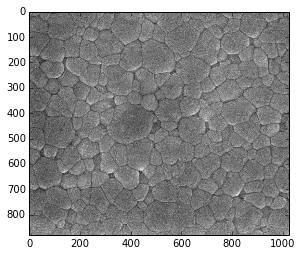

In [4]:
plt.imshow(im, cmap='gray')

##Denoising the image

The image is quite noisy, probably because of counting noise. Let us start by denoising the image, since further steps will be easier on a denoised image (for examples, image gradients will be more likely to represent image features than noise). 

Several denoising filters are available in scikit-image. A suitable denoising filter should smoothen heavily the interior of grains, while keeping sharp edges between grains. Here we use the non-local means filter [1], that averages a pixel with other pixels under the condition that patches centered  on the two pixels look similar. This filter has the property to preserve textures well: here, it is important to preserve well the weak edges between grains, while smoothing significantly the interior of the grains. Using a non-local means filter here is a bit of an overkill, I admit, but since it is fast enough compared to other operations that we're going to perform, I chose to use the Rolls-Royce anyway.

[1] Buades, A., Coll, B., & Morel, J. M. (2005, June). A non-local algorithm for image denoising. In Computer Vision and Pattern Recognition, 2005. CVPR 2005. IEEE Computer Society Conference on (Vol. 2, pp. 60-65). IEEE.

In [5]:
from skimage import restoration
from skimage import img_as_float
im_float = img_as_float(im)

In [6]:
im_denoised = restoration.nl_means_denoising(im_float, h=0.05)

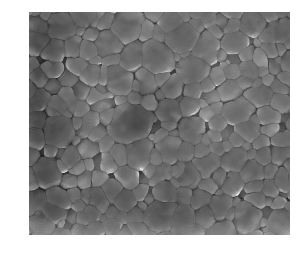

In [7]:
plt.imshow(im_denoised, cmap='gray')
ax = plt.axis('off')

Now, how can we obtain a good segmentation of the denoised image? A difficulty is that neighboring grains have very similar gray values, and grains can be distinguised only thanks to thin boundaries of darker gray level. Such boundaries cannot be segmented easily by thresholding the image (since the contrast varies through the image), or by using an edge detector (such a Canny filter). Even if some edges are well detected by a Canny filter (after some tuning of filter parameters), edges with weaker contrast cannot be detected.

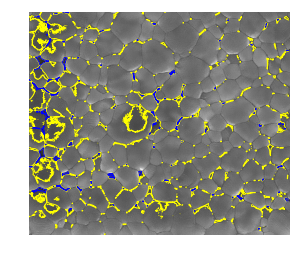

In [8]:
# Try to threshold the image
plt.imshow(im_denoised, cmap='gray')
plt.contour(im_denoised, [0.5], colors='yellow')
plt.contour(im_denoised, [0.45], colors='blue')
ax = plt.axis('off')

<matplotlib.contour.QuadContourSet instance at 0x7fc25bcb68c0>

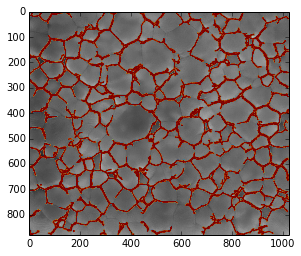

In [9]:
# Try to detect edges with Canny filter
from skimage import feature
edges = feature.canny(im_denoised, sigma=0.2, low_threshold=0.07, \
                      high_threshold=0.18)
plt.imshow(im_denoised, cmap='gray')
plt.contour(edges)

##Semi-supervized approach: segmenting the image from user-defined markers

A change of tack is therefore required: instead of focusing on edge pixels, we will try to group together pixels that are in the same smooth region, and make sure that boundaries between regions correspond to zones of high gradient. Segmentations matching such criteria can be obtained thanks to several graph-based algorithms, among which the **watershed** or the **random walker** algorithms that are available in ``scikit-image``.

Nevertheless, both algorithms require a set of *markers* or *seeds*, that is, pixels of known label from which region growing is performed. Several strategies are possible for choosing the labels. If you're patient enough, it is possible to determine markers by clicking inside each grain, using matplotlib's ``ginput`` function.

```
plt.imshow(im_denoised, cmap='gray')
click_markers = plt.ginput(n=-1, timeout=-1)
```

Unfortunately, ``ginput`` does not work in Ipython notebooks with inline plotting of figure, so you will have to use the console version of Ipython. For this example, I clicked inside all grains that I could distinguish, and I saved the coordinates in a file. The positions of the markers are represented below.

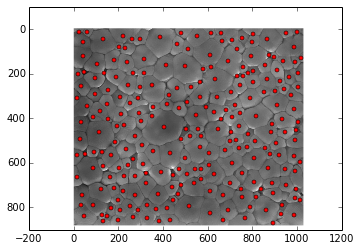

In [10]:
x, y = np.load('indices_markers.npy').T
plt.imshow(im_denoised, cmap='gray')
plt.plot(y, x, 'or', ms=4)

Let us first define an array of markers, where each marker corresponds to a different label. In order to reduce the sensitivity to local variations of gray levels, we thicken marker points using a [morphological dilation][1], which is equivalent to a maximum filter. Markers therefore correspond to small disks of pixels, all with the same label.

[1]: https://en.wikipedia.org/wiki/Dilation_(morphology)

In [11]:
from skimage import morphology
markers = np.zeros(im_denoised.shape, dtype=np.int)
markers[x.astype(np.int), y.astype(np.int)] = np.arange(len(x)) + 1
markers = morphology.dilation(markers, morphology.disk(7))

###Watershed segmentation

Let us try using watershed segmentation first. The watershed algorithm uses an image considered as an elevation map (like a topographic map) and gradually floods the image, starting from the markers. The choice of a good elevation map is paramount for watershed segmentation, since boundaries between regions will correspond to the watershed lines of the elevation map. A common choice is to use the gradient of the image to determine the elevation map, or a distance map to the background -- but we do not have a background phase here, which is one of the difficulties of the image. Here, we make use of the darker gray levels of boundaries and use a morphological operation called [**black tophat**](https://en.wikipedia.org/wiki/Top-hat_transform), that detects structures that are darker than their surroundings, and smaller than a structuring element. In order to enhance edges, we use a linear combination of the black tophat and the denoised image. For a different try, we also use a [Laplace filter with Gaussian derivatives](https://en.wikipedia.org/wiki/Difference_of_Gaussians), that should enhance sharp edges.

Note that there exists a large number of different version of the watershed algorithm, and that using a different version might result in a different segmentation.

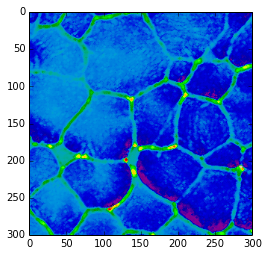

In [12]:
from scipy import ndimage
from skimage import morphology
# Black tophat transformation (see https://en.wikipedia.org/wiki/Top-hat_transform)
hat = ndimage.black_tophat(im_denoised, 7)
# Combine with denoised image
hat -= 0.3 * im_denoised
# Morphological dilation to try to remove some holes in hat image
hat = morphology.dilation(hat)
plt.imshow(hat[:300, :300], cmap='spectral')

We now apply the watershed algorithm on the laplacian image, using the markers array. In order to visualize the result, we use a dedicated function of ``scikit-image``, ``color.label2rgb``, that superimposes the segmentation (an array of integers, with different labels corresponding to different objects) on the initial image.

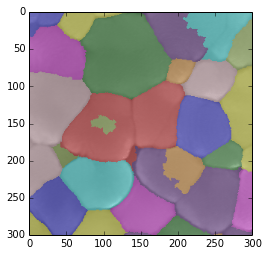

In [13]:
labels_hat = morphology.watershed(hat, markers)
from skimage import color
color_labels = color.label2rgb(labels_hat, im_denoised)
plt.imshow(color_labels[:300, :300])

<matplotlib.colorbar.Colorbar instance at 0x7fc25ab1cd40>

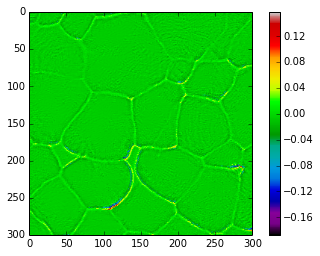

In [14]:
# A different markers image: laplace filter
lap = ndimage.gaussian_laplace(im_denoised, sigma=0.7)
lap = restoration.nl_means_denoising(lap, h=0.002)
plt.imshow(lap[:300, :300], cmap='spectral'); plt.colorbar()

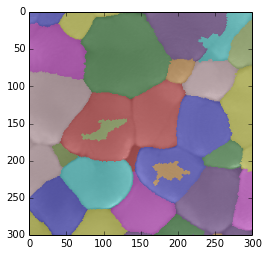

In [15]:
labels_lap = morphology.watershed(lap, markers)
color_labels = color.label2rgb(labels_lap, im_denoised)
plt.imshow(color_labels[:300, :300])

So, are we satisfied with the segmentation obtained from the watershed? Most grains are correctly segmented, with boundaries accurately delineated. However, some grains appear to have "leaked" into other ones. Such errors come from the fact that boundaries between grains have some "holes" - to pursue with the analogy of the topographic map, the wall between basins of the two grains has a breach, allowing water to flood the other basin. It is possible that 1) a better elevation map (without holes) or 2) a better watershed algorithm would avoid such problems; if you have ideas, I'm interesting in learning more.

###Random walker segmentation

The **random walker** algorithm [1] is based on anisotropic diffusion from seeded pixels, where the local diffusivity is a decreasing function of the image gradient. Random walker segmentation is more robust to "leaky" boundaries than watershed segmentation. 

[1] Grady, L. (2006). Random walks for image segmentation. Pattern Analysis and Machine Intelligence, IEEE Transactions on, 28(11), 1768-1783.

However, it is also much slower than the watershed, and the execution time scales as the number of labels. In order to reduce this time, we re-label the seeds to be sure that neighboring regions will have different labels. We first extract a graph of nearest neighbors using a dedicated function from ``scikit-learn``, then we use a **vertex coloring** algorithm from ``pyamg`` to ensure that vertex sharing an edge have different colors (like in the 4-color theorem). 

There is **no guarantee** that this trick is sound to use for a generic image, since regions can have complicated shapes and have a large number of neighboring regions, with markers that do not correspond to nearest neighbors. In the image of interest here, regions have compact shapes, most of them convex, so it safer to use this trick here than in the general case.

In [16]:
# Graph of nearest neighbors (15 nearest neighbors)
from sklearn.neighbors import kneighbors_graph
mat = kneighbors_graph(np.array([x, y]).T, 15)

In [17]:
# Color the graph using a small number of colors
from pyamg.graph import vertex_coloring
colors = vertex_coloring(mat)
colors.max(), len(x)

(10, 241)

In [18]:
# Array of markers
markers_rw = np.zeros(im_denoised.shape, dtype=np.int)
markers_rw[x.astype(np.int), y.astype(np.int)] = colors + 1
markers_rw = morphology.dilation(markers_rw, morphology.disk(5))

We can now execute the random walker segmentation on the denoised image (no need to define another image as for the watershed), using the array of markers. An important parameter of the function is the ``beta`` parameter. The larger ``beta``, the more difficult the diffusion. Use a large ``beta`` to prevent "leakage" through weak boundaries.

In [19]:
from skimage import segmentation
labels_rw = segmentation.random_walker(im_denoised, markers_rw,\
                                       beta=25000, mode='cg_mg')

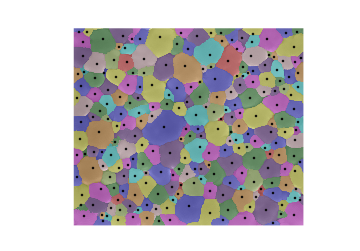

In [20]:
plt.imshow(color.label2rgb(labels_rw, im_denoised))
plt.plot(y, x, 'ok', ms=2)
ax = plt.axis('off')

As shown above, the result of the segmentation is quite satisfying, with boundaries following accurately zones of high gradient between the grains. 

So, if you can afford the time to manually click on marker points, an accurate segmentation is possible. Nevertheless, it is a tedious task, all the more if you have a large number of images in which to determine markers. What's more, computer time is cheaper than human time. Is it possible to automate this process?

## Automatic segmentation

A possible way to determine markers is to draw random pixels of the image. The underlying idea of using random markers is that there are some "natural boundaries" inside the image, corresponding to the grain boundaries that are looked for, and that a segmentation using random markers will have a fraction of its boundaries lying on such natural boundaries. By averaging on a large number of segmentations corresponding to different realizations of the markers, one hopes that pixels lying on the looked-for boundaries will lie on segmentation boundaries more often than other pixels.

Since we know that the objects to segment have a minimal size, markers that are too close to each other lead to boundaries that are seldom found on grain boundaries. Therefore, we impose that random markers should have a minimal distance between each other, using ``scipy.spatial.KDTree`` to compute pairs of markers closer than a certain distance. We will also use the coloring trick to reduce the number of labels.

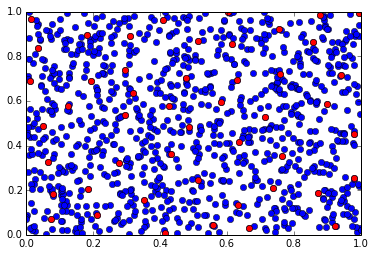

In [21]:
from scipy import spatial

def trim_close_points(points, distance=1):
    """
    Greedy method to remove some points so that
    all points are separated by a distance greater
    than ``distance``.
    
    points : array of shape (2, n_points)
        Coordinates of 2-D points
        
    distance : float
        Minimal distance between points
    """
    x, y = points
    tree = spatial.KDTree(np.array([x, y]).T)
    pairs = tree.query_pairs(distance)
    remove_indices = []
    for pair in pairs:
        if pair[0] in remove_indices:
            continue
        if pair[1] in remove_indices:
            continue
        else:
            remove_indices.append(pair[1])
    keep_indices = np.setdiff1d(np.arange(len(x)), remove_indices)
    return np.array([x[keep_indices], y[keep_indices]])

# Check result on simple example
x, y = np.random.random((2, 1000))
xk, yk = trim_close_points((x, y), 0.1)
plt.plot(x, y, 'o')
plt.plot(xk, yk, 'or')


Now we perform a large number of random walker segmentations, using different sets of markers. To reduce the computing time, I used a downsampled array here. However, executing the cell below still took 50 minutes on my machine! If you would like to reproduce the results here, you can start from a smaller number of realizations, like 50. 

Also, the method of computing segmentations from different sets of markers belongs to the class of *embarassingly parallel* problems, so that it is easy to parallelize this part. For this purpose, you can use the ``joblib`` library, that provide a helper function ``Parallel`` for simple parallelization.

In [22]:
from time import time
n_real = 400
n_markers = 1000
segmentations = []
t1 = time()
for real in range(n_real):
    # Random markers
    x, y = np.random.random((2, n_markers))
    x *= im_denoised.shape[0]
    y *= im_denoised.shape[1]
    # Remove points too close to each other
    xk, yk = trim_close_points((x, y), 20)
    mat = kneighbors_graph(np.array([xk, yk]).T, 12)
    colors = vertex_coloring(mat)
    # Array of markers
    markers_rw = np.zeros(im_denoised.shape, dtype=np.int)
    markers_rw[xk.astype(np.int), yk.astype(np.int)] = colors + 1
    markers_rw = morphology.dilation(markers_rw, morphology.disk(3))
    # Segmentation
    labels_rw = segmentation.random_walker(im_denoised[::2, ::2], 
                                           markers_rw[::2, ::2],\
                                       beta=25000, mode='cg_mg')
    segmentations.append(labels_rw)
t2 = time()
print(t2 - t1)

3224.99918485


Now we extract boundary pixels for each segmentation using a dedicated function ``segmentation.find_boundaries``, and we add all these boundary images.

In [23]:
segmentations = np.array(segmentations)
boundaries = np.zeros_like(im_denoised[::2, ::2])
for seg in segmentations:
    boundaries += segmentation.find_boundaries(seg, connectivity=2)


<matplotlib.colorbar.Colorbar instance at 0x7fc2577f4050>

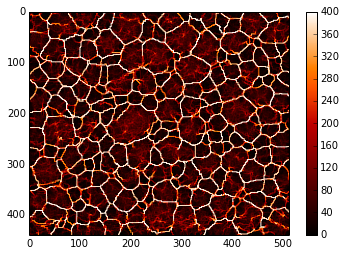

In [24]:
plt.imshow(boundaries, cmap='gist_heat'); plt.colorbar()

We can see that the boundaries of grains are quite well delineated, although boundaries appear darker in places: a simple thresholding will either cut boundaries in two, or result in spurious boundaries inside grains. To improve over a simple thresholding, we use a method called *hysteresis thresholding*, that is used in the Canny filter to produce smooth edges: we keep slightly darker parts if they are connected to brighter parts, using two different thresholds. This method is useful to keep darker parts of bright regions.

Note that some points (as can be seen from the colorbar values) were labeled as boundary points in almost all segmentations!

In [25]:
def hysteresis_thresholding(im, v_low, v_high):
    """
    Parameters
    ----------
    im : 2-D array
    
    v_low : float
        low threshold
        
    v_high : float
        high threshold
    """
    mask_low = im > v_low
    mask_high = im > v_high
    # Connected components of mask_low
    labels_low = measure.label(mask_low, background=0) + 1
    count = labels_low.max()
    # Check if connected components contain pixels from mask_high
    sums = ndimage.sum(mask_high, labels_low, np.arange(count + 1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums[1:] > 0
    output_mask = good_label[labels_low]
    return output_mask    

In order to check the effect of thresholding parameters, we write helper functions that produce meaningful visualizations of the segmentation. 

Segmented regions are extracted as connected components in an image where background pixels are the boundaries determined from hysteresis thresholding.

In [26]:
from skimage import measure, color


def color_segmentation(regions, n_neighbors=25):
    """
    Reduce the number of labels in a label image to make
    visualization easier.
    """
    count = regions.max()
    centers = ndimage.center_of_mass(regions + 2, regions, 
                                     index=np.arange(1, count + 1))
    centers = np.array(centers)
    mat = kneighbors_graph(np.array(centers), n_neighbors)
    colors = vertex_coloring(mat)
    colors = np.concatenate(([0], colors))
    return colors[regions]                       


def plot_colors(val_low, val_high):
    """
    Plot result of segmentation superimposed on original image,
    and plot original image as well.
    """
    seg = hysteresis_thresholding(boundaries, val_low, val_high)
    regions = measure.label(np.logical_not(seg),
                            background=0, connectivity=1)
    color_regions = color_segmentation(regions)
    colors = [plt.cm.spectral(val) for val in 
                   np.linspace(0, 1, color_regions.max() + 1)]
    image_label_overlay = color.label2rgb(color_regions, 
                                          im_denoised[::2, ::2],
                                          colors=colors)
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(image_label_overlay)
    plt.subplot(122)
    plt.imshow(im_denoised, cmap='gray')
    return regions

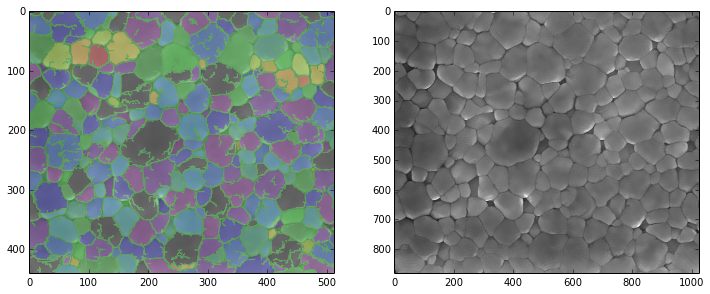

In [27]:
regions = plot_colors(0.3 * n_real, 0.55 * n_real)

Once that a good pair of thresholds has been found, it is possible to clean the segmentation by removing small connected components. We relabel labels so that there are no missing labels. 

Below, we use a visualization trick so that neighboring regions have different colors: we shuffle labels using ``np.random.permutation``.

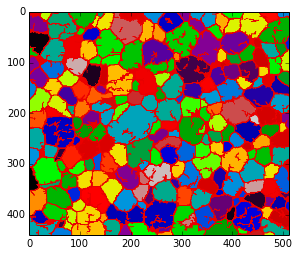

In [28]:
regions_clean = morphology.remove_small_objects(regions + 1, min_size=60)
regions_clean, _, _ = segmentation.relabel_sequential(regions_clean)
plt.imshow(np.random.permutation(regions_clean.max() + 1)[regions_clean],
                   cmap='spectral')

In order to finish the segmentation and to label pixels that have been labeled as boundaries (some of them being "real boundaries", other not), several possibilities exist, such as using mathematical morphology operations. Here, we'll continue using the random walker to attribute the remaining unknown pixels. We could use the coloring trick again, but since the number of pixels to be determined is small, it is not a big deal not to use it.

In [29]:
final_segmentation = segmentation.random_walker(im_denoised[::2, ::2], 
                                                regions_clean,
                                                beta=25000, mode='cg_mg')

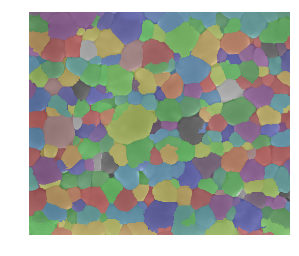

In [30]:
plt.imshow(color.label2rgb(final_segmentation, im_denoised[::2, ::2],
                    colors=plt.cm.spectral(np.linspace(0, 1, 40))))
ax = plt.axis('off')

We can use different colors if we want to make sure that some pairs of neighboring grains have different labels.

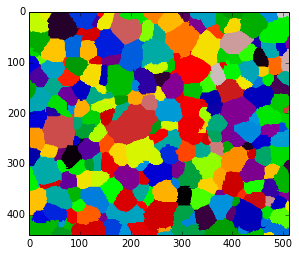

In [31]:
plt.imshow(np.random.permutation(final_segmentation.max() + 1)
                                    [final_segmentation], 
                                    cmap='spectral')

It was therefore possible to reach a satisfying segmentation in a more automatic way. Depending on your image, it is possible that segmentation from random markers using the watershed algorithm can also result in a good segmentation, in which you can save a lot of time.

Note that it would be possible to improve an automatic segmentation by clicking on a few regions that would not have been segmented correctly, and applying the random walker to these regions.

##A few take-home messages


* You may have noticed that an important fraction of code lines consist of NumPy machinery. Therefore, image processing with Python requires to understand image processing algorithms, but also to be fluent enough with NumPy operations such as indexing, masking, changing shape and data type, operations on sets, etc. 

* Along the same lines, we used several functions and submodules from ``scikit-image``, but we also leveraged functions from ``scipy.ndimage``, ``scipy.spatial``, ``sklearn.graph``, ``pyamg`` (and of course ``matplotlib``). I think this usecase brings to light a huge advantage of the Scientific Python ecosystem, that is the "batteries included" philosophy.

* Using a semi-supervized approach (by clicking on markers) or a fully automatic one both have pros and cons. The automatic approach is more error-prone, but then you'll typically use it in cases where you have a large number of objects. Depending on your application, a fraction of errors may be acceptable. 